In [16]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "slumlordreach" # 21st_year, pieman, slumlordreach, black
MODEL = 'bert-large-uncased' # bert-base-uncased, bert-large-uncased || GPT: gpt2, gpt2-xl, gpt-neo-2.7B

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/slumlordreach/tr_tokens.csv
Loaded 1177 TRs.


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Layerwise Activations

In [ ]:
foo.process_stimulus_activations()

In [ ]:
foo.model_name

In [ ]:
SAVE_QKV_VECTORS = False

for layer in range(0, 12):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
    
    print(layer_mean_embeddings.shape)
    
    layer_z_reps = foo.layer_activations_from_tensor(foo.stimulus_df["z_reps"], layer)
    layer_mean_z_reps = np.array([l.mean(0).numpy() for l in layer_z_reps])
    np.save("{}_{}_layer_{}_z_representations.npy".format(STIMULUS, MODEL, layer), layer_mean_z_reps)
    
    print(layer_mean_z_reps.shape)

    if SAVE_QKV_VECTORS: 
        for representation in ["query", "key", "value"]:
            all_reps = foo.layer_activations_from_tensor(foo.stimulus_df["query"], layer)
            mean_rep = np.array([l.mean(0).numpy() for l in all_reps])
            np.save("{}_{}_layer_{}_{}.npy".format(STIMULUS, MODEL, layer, representation), mean_rep)
            print("Processed {} layer {} --> {}.".format(representation, layer, mean_rep.shape))

layer_glove = foo.layer_activations_from_tensor(foo.stimulus_df["glove"], 0)
np.save("{}_{}_layer_{}_glove.npy".format(STIMULUS, MODEL, 0), layer_glove)
#     df["layer_{}".format(layer)] = layer_mean_embeddings

In [ ]:
ALL_LAYER_REPS = "scp {}_{}_layer_*_activations.npy {}_{}_layer_*_z_representations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/raw_embeddings"

print("SCP all model layers and z-reps to PNI:\n")

print(ALL_LAYER_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL))

# Attention Vectors
Important question: how many prior tokens should we take for attention metric context?

In [ ]:
print(foo.stimulus_df.n_transformer_tokens_in_tr.describe())
foo.stimulus_df.n_transformer_tokens_in_tr.hist(bins=20);
plt.suptitle("Number of Transformer Tokens per TR")
plt.xlabel("Number of Tokens");

In [ ]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens. (yikes-- we've been doing 20!)

N_ATTENTION_TOKENS = 10 # 20, 128

In [ ]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

In [ ]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

In [ ]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

# Masking Attention

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [ ]:
BACKWARD_ATTENTION = False

if BACKWARD_ATTENTION:
    ATTENTION_DIRECTION = "bck"
else:
    ATTENTION_DIRECTION = "fwd"

In [ ]:
foo.mask_non_tr_attentions(include_forwards=not BACKWARD_ATTENTION, 
                           include_backwards=BACKWARD_ATTENTION)

In [104]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p='inf')

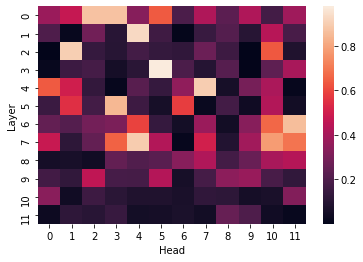

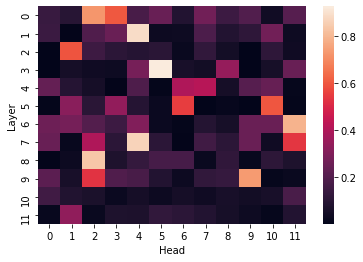

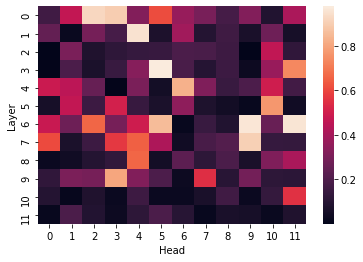

In [105]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")
    
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention for Single Head ({} Total Tokens)".format(N_ATTENTION_TOKENS));

sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention for Single Head ({} Total Tokens)".format(ATTENTION_DIRECTION, N_ATTENTION_TOKENS));

# Outputs for Sreejan

In [111]:
import itertools

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

### Syntactic Complexity

In [112]:
for p in [1, 'inf']:  # can also do p=2, but not using that currently.

    COMPLEXITY_OUTPUT_FILE = "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, ATTENTION_DIRECTION)
    print("Outputting metrics to {}".format(COMPLEXITY_OUTPUT_FILE))

    attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))

    attention_np_arrays = np.array(attention_vectors)
    print(attention_np_arrays.shape)
    np.save(COMPLEXITY_OUTPUT_FILE, attention_np_arrays)

Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
(534,)
Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
(534,)


In [156]:
import random

def concatenate_fwd_bck_arrays(fwd, bck):

    nonzero_fwd = 0
    total_fwd = 0
    nonzero_bck = 0
    total_bck = 0
    
    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:
            if random.random() > .95:
                
                nonzero_fwd += len([v for v in f if v > 1e-5])
                total_fwd += len(f)
                nonzero_bck += len([v for v in b if v > 1e-5])
                total_bck += len(b)
                
            res.append(f + b)
    res = np.array(res, dtype=object)
    
#     print("\tFound {}/{} and {}/{} nonzero.".format(nonzero_fwd, total_fwd, nonzero_bck, total_bck))
    
    return res

In [157]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
#     print(concat.shape)
#     print(len(concat[-10]))
#     print(backwards_file + "\n" + forward_file + "\n" + concat_file + "\n=======")

    

	Found 7616/7632 and 7632/7632 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-concat.npy
	Found 3713/3744 and 3744/3744 nonzero.
(534,)
288
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy
	Found 9325/9360 and 9360/9360 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy
	Found 6739/6768 and 6768/6768 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
slumlordreach_bert-base-u

In [ ]:
## SCP to PNI

```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [37]:


SCP_STIMULUS='black'

ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(SCP_STIMULUS, MODEL, SCP_STIMULUS, MODEL, SCP_STIMULUS, MODEL))

SCP all syntactic representations to PNI:

scp black_gpt2_syntactic_*.npy black_gpt2_semantic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/gpt2/syntactic_analyses


# DEMO: attention distance masking
Just in case I want to double check this logic sometime.

In [5]:
import numpy as np
N_TOKENS = 5
a = np.array(range(1,N_TOKENS+1))
columns = np.tile(a,(N_TOKENS,1))
rows = np.tile(a,(N_TOKENS,1)).T
abs((rows-columns))

array([[0, 1, 2, 3, 4],
       [1, 0, 1, 2, 3],
       [2, 1, 0, 1, 2],
       [3, 2, 1, 0, 1],
       [4, 3, 2, 1, 0]])